# Generative Adverserial Networks (GAN) example in PyTorch

Source: https://github.com/devnag/pytorch-generative-adversarial-networks/blob/master/gan_pytorch.py

In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Data parameters
data_mean = 4
data_std = 1.5

In [21]:
#True distribution - Gaussian
def get_distribution_sampler(mu, sigma):
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n)))

#Uniform distribution generator. In practice, for others, we can generate a 
def get_generator_sampler():
    return lambda m, n: torch.rand(m,n)

In [22]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.dense3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.dense1(x))
        x = F.sigmoid(self.dense2(x))
        return self.dense3(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.dense3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.dense1(x))
        x = F.elu(self.dense2(x))
        return F.sigmoid(self.dense3(x))

In [48]:
# Model parameters
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 1   # 
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = 256


In [50]:
#Training parameters
d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 1000
print_interval = 200
d_steps = 2  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [35]:
d_sampler = get_distribution_sampler(data_mean, data_std)
g_sampler = get_generator_sampler()
G = Generator(g_input_size, g_hidden_size, g_output_size)
D = Discriminator(d_input_size, d_hidden_size, d_output_size)
criterion = nn.BCELoss() #Binary cross entropy
d_opt = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_opt = optim.Adam(G.parameters(), lr=d_learning_rate, betas=optim_betas)

G.cuda()
D.cuda()

Discriminator (
  (dense1): Linear (1 -> 50)
  (dense2): Linear (50 -> 50)
  (dense3): Linear (50 -> 1)
)

In [51]:
for epoch in range(num_epochs):
    #D Training loop
    for _ in range(d_steps):
        
        #Train D here
        D.zero_grad()
        
        real_data = Variable(d_sampler(minibatch_size, d_input_size)).cuda()
        real_preds = D(real_data)
        real_error = criterion(real_preds, Variable(torch.ones(minibatch_size)).cuda())
        real_error.backward()
        
        fake_data = G(Variable(g_sampler(minibatch_size, g_input_size)).cuda()) #.detach()
        fake_preds = D(fake_data)
        fake_error = criterion(fake_preds, Variable(torch.zeros(minibatch_size)).cuda())
        fake_error.backward()
        
        d_opt.step()
        
    for _ in range(g_steps):
        G.zero_grad()
        D.zero_grad()
        #Train G here
        fake_data = G(Variable(g_sampler(minibatch_size, g_input_size)).cuda())
        fake_preds = D(fake_data)
        g_error = criterion(fake_preds, Variable(torch.ones(minibatch_size)).cuda()) #Max error for discriminator
        
        g_error.backward()
        g_opt.step() #Only optimize G
        
    if epoch % 200 == 0:
        print("%s: D: %.3f/%.3f G: %.3f. G-data stats: %.2f, %.2f" % (epoch,
                                    real_error.data[0],
                                    fake_error.data[0],
                                    g_error.data[0],
                                    fake_data.mean().data[0],
                                    fake_data.std().data[0]))   
        
        

0: D: 0.680/0.678 G: 0.711. G-data stats: 4.04, 1.34
200: D: 0.685/0.683 G: 0.717. G-data stats: 4.07, 1.35
400: D: 0.702/0.667 G: 0.718. G-data stats: 3.92, 1.45
600: D: 0.669/0.694 G: 0.705. G-data stats: 3.87, 1.43
800: D: 0.691/0.682 G: 0.700. G-data stats: 4.11, 1.36


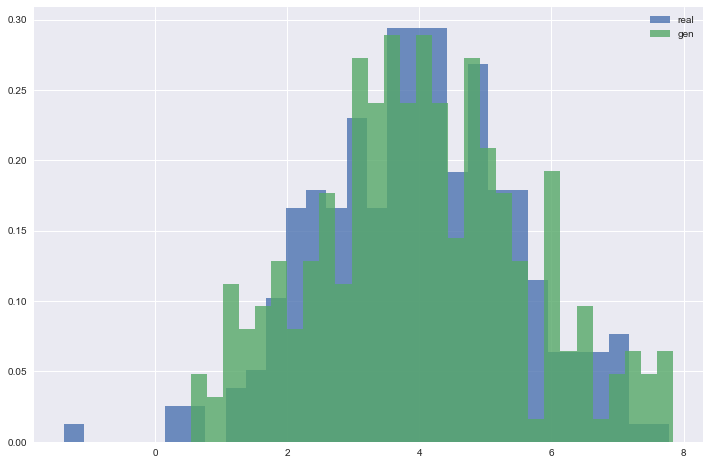

In [70]:
#Lets perform some further analysis on the data generated

samples = 1024
bins = 30
real_samples = d_sampler(minibatch_size, d_input_size).numpy().flatten()
gen_samples = G(Variable(g_sampler(minibatch_size, g_input_size)).cuda()).data.cpu().numpy().flatten()

plt.figure(figsize=(12,8))
plt.hist(real_samples, bins, normed=True, alpha=0.8, label='real')
plt.hist(gen_samples, bins, normed=True, alpha=0.8, label='gen')
plt.legend(loc='upper right')
plt.show()